# Obtenção dos modos de vibrar utilizando método da FRF

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.fft as fft

import PyOMA as oma
from scipy.interpolate import interp2d

In [15]:
# Definimos os parâmetros amostrais
fs = 1024 # taxa de amostragem
tf = 256 # tempo total 
Np = fs*tf # número de pontos
t = np.linspace(0,tf,Np,endpoint=False)

#Import dos dados
df = np.asarray(pd.read_table('..\..\Dataset\Treino dataset\zzzAA0.TXT', sep='\t', skiprows=10))
t = df[:,0:]
df = df[:,1:]

Decimating...
Decimated
Filtering...
Filtered


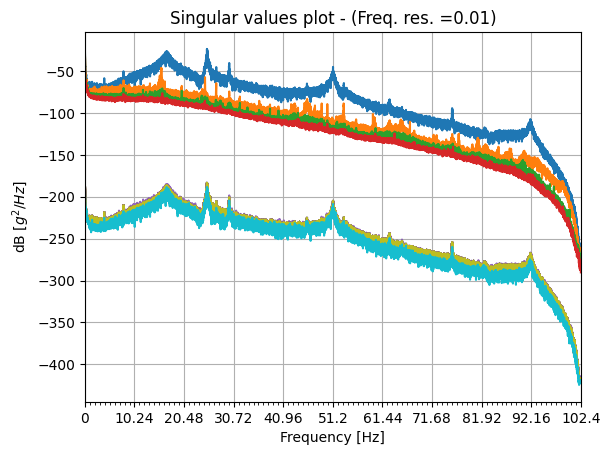

In [16]:
print('Decimating...')
q = 5 # Decimation factor
df = signal.decimate(df,  q, ftype='fir', axis=0) # Decimation
fs = fs/q # [Hz] Decimated sampling frequency
print('Decimated')

print('Filtering...')
b, a = signal.butter(2, 100, 'low', fs=1024)
for i in range(df.shape[1]):
        df[:,i] = signal.filtfilt(b, a, df[:,i], padlen=150)

print('Filtered')
##############TESTE PYOMA####################
FDD = oma.FDDsvp(df,  fs)


In [28]:
FreQ = [17.4, 24.57]
Res_FDD = oma.FDDmodEX(FreQ, FDD[1]) # extracting modal properties using standard FDD

print(f"Frequências: {Res_FDD['Frequencies']}")
Res_FDD['Mode Shapes']

Frequências: [17.38183594 24.58359375]


array([[ 5.78417920e-01+1.13344306e-02j,  4.24769058e-01-5.00894182e-03j],
       [ 8.85384160e-01+1.11933640e-02j,  6.62206344e-01-9.44991686e-03j],
       [ 1.00000000e+00-0.00000000e+00j,  7.93925846e-01-2.34262673e-02j],
       [ 9.18358422e-01+8.95900802e-03j,  8.02740044e-01-1.12630614e-02j],
       [ 6.60900953e-01+8.20741858e-03j,  6.94880910e-01-4.77389188e-03j],
       [ 3.64806973e-01+6.13340322e-03j,  4.67871932e-03-5.01852653e-04j],
       [ 6.27121708e-01+8.29651120e-03j, -9.71058518e-03-3.42449539e-03j],
       [ 7.17022853e-01+7.15367680e-03j, -3.42467822e-02-2.87824302e-03j],
       [ 6.23319376e-01+6.89004331e-03j, -1.62496040e-02-2.64006974e-03j],
       [ 3.52296235e-01+4.44087529e-03j,  1.04971017e-03-3.66720350e-03j],
       [ 2.98377756e-01+2.89107607e-03j, -1.26288808e-01-3.71067352e-03j],
       [ 4.66718080e-01+2.40207374e-03j, -2.20170394e-01-7.07620727e-03j],
       [ 5.30187633e-01+4.34719495e-03j, -3.02170964e-01-2.33661953e-03j],
       [ 4.49320249e-01+3

Obtendo a FRF (Acelerância)

Pontos por janela: 2048


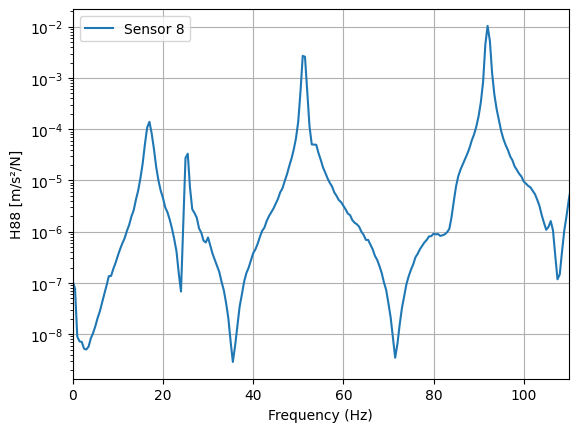

In [4]:
n_window = len(t)//128
print('Pontos por janela:', n_window)
w, H88 = signal.welch(df[:,7], fs=fs, window='hann', nperseg=n_window)

plt.semilogy(w, np.abs(H88), label='Sensor 8')
# plt.scatter(w,abs(H88))
plt.xlabel('Frequency (Hz)')
plt.ylabel('H88 [m/s²/N]')
plt.xlim([0,110])
plt.grid()
plt.legend()
plt.show()

Estimativa dos parâmetros modais

In [59]:
#Integrando para obter a Receptância
H = (-H88/(w*2*np.pi)**2)

#vetor de faixas de frequências
freqs = [[8,22],[24.5,26.5]]

wn = np.zeros(len(freqs))
zeta = np.zeros(len(freqs))
A88 = np.zeros(len(freqs))
modos_88 = np.zeros(len(freqs))

for i in range(len(freqs)):
    fi = int(np.where(w==freqs[i][0])[0]) #posição do vetor inicial
    ff = int(np.where(w==freqs[i][1])[0]) #posição do vetor inicial
    fwn = fi+np.argmax(np.abs(H[fi:ff]))
    wn[i] = 2*np.pi*w[fwn]
    print('wn1 = ', wn[i]/2/np.pi,' Hz')

    # Meia potência
    Bandwith = np.max(np.abs(H[fi:ff]))/np.sqrt(2)
    w1 = 2*np.pi*w[fi+np.abs(np.abs(H[fi:fwn])-Bandwith).argmin()]
    w2 = 2*np.pi*w[fwn+np.abs(np.abs(H[fwn:ff])-Bandwith).argmin()]
    zeta[i] = (w2-w1)/(2*wn[i])
    print('zeta1 = ', zeta[i])

    A88[i] = np.max(np.abs(H[fi:ff]))*2*zeta[i]*wn[i]**2
    modos_88[i] = -np.sqrt(A88[i])
    print(A88[i])

wn1 =  17.0  Hz
zeta1 =  0.022058823529411756
7.52534754453761e-06
wn1 =  25.25  Hz
zeta1 =  0.009900990099009868
1.3810430102871524e-06


C:\Users\Guilherme Zerwes\AppData\Local\Temp\ipykernel_3796\3387201378.py:2: RuntimeWarning: divide by zero encountered in divide
  H = (-H88/(w*2*np.pi)**2)
C:\Users\Guilherme Zerwes\AppData\Local\Temp\ipykernel_3796\3387201378.py:2: RuntimeWarning: invalid value encountered in divide
  H = (-H88/(w*2*np.pi)**2)


In [69]:
#Utilizando a constante modal do modo forçado para determinar as demais
H = np.zeros((df.shape[1], H88.shape[0]), dtype=complex)
A = np.zeros((df.shape[1],len(freqs)))
modos = np.zeros((df.shape[1], len(freqs)))

for i in range(len(df[0,:])):
    _, H[i,:] = signal.csd(df[:,i], df[:,7], fs=fs, window='hann', nperseg=int(df.shape[0]/64), 
                nfft=int(df.shape[0]/64), detrend='constant', return_onesided=True, scaling='density', 
                axis=-1, average='mean')
    for j in range(len(freqs)):
        A[i,j] = np.max(np.abs(H[i,fi:ff]))*2*zeta[j]*wn[j]**2
        modos[i,j] = A[i,j]/modos_88[j]
print(modos)

[[ -26.10349247  -60.33641437]
 [ -35.09542762  -81.12064952]
 [ -38.60575714  -89.23453301]
 [ -36.68655284  -84.79842522]
 [ -30.29086811  -70.01524307]
 [  -6.96902833  -16.10842617]
 [ -11.14274007  -25.75567169]
 [ -12.79691316  -29.57917819]
 [ -10.42077974  -24.08691041]
 [  -5.44917742  -12.59539608]
 [ -20.27307895  -46.85981746]
 [ -29.28774289  -67.69658862]
 [ -32.77425814  -75.75542707]
 [ -29.32948779  -67.79307907]
 [ -19.92735419  -46.06069863]
 [ -13.62124481  -31.48456369]
 [ -17.76846212  -41.07056917]
 [ -19.75768888  -45.66852903]
 [ -18.25182418  -42.18782709]
 [ -14.22517903  -32.88051581]
 [  -9.94288367  -22.98228676]
 [ -19.42992474  -44.91092492]
 [ -23.18392398  -53.58803409]
 [ -18.97598724  -43.86167983]
 [  -9.1229583   -21.08708607]
 [ -37.6759916   -87.08544438]
 [ -65.97810893 -152.5038278 ]
 [ -77.88708896 -180.03061007]
 [ -65.98649635 -152.52321473]
 [ -38.1112342   -88.0914775 ]]


Visualização dos dados

In [ ]:
for i in range(len(freqs)):
    X = np.arange(0, 6, 1)
    Y = np.arange(0, 5, 1)
    X, Y = np.meshgrid(X, Y)
    Z = modos[:,i].reshape((5,6))

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False, rcount=200, ccount=200)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    title = f'{i+1}º modo de vibrar'
    plt.title(title)
    plt.xlabel('Sensors in x')
    plt.ylabel('Sensors in y')

    # plt.show()

In [ ]:
for i in range(len(freqs)):
    heat = modos[:,i].reshape(6,5)
    fig = plt.figure(i)
    plt.imshow(heat, interpolation='bilinear', cmap='jet')
    plt.grid()
    plt.colorbar(extend='both')
    title = f'{i+1}º modo de vibrar'
    plt.title(title)
    plt.xlabel('Sensors in x')
    plt.ylabel('Sensors in y')
    # plt.savefig(f'./outputs/graficos/validation heatmap {i}.png')
    # plt.show()

In [ ]:
from scipy.interpolate import interp2d

for i in range(len(freqs)):
    X = np.arange(0, 6, 1)
    Y = np.arange(0, 5, 1)
    Z = modos[:,i]

    x2 = np.linspace(0, 6, 60)
    y2 = np.linspace(0, 5, 50)
    f = interp2d(X, Y, Z, kind='cubic')
    Z2 = f(x2, y2)

    X2, Y2 = np.meshgrid(x2, y2)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X2, Y2, Z2, cmap='jet', linewidth=0, antialiased=False, rcount=200, ccount=200)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    title = f'{i+1}º modo de vibrar'
    plt.title(title)
    plt.xlabel('Sensors in x')
    plt.ylabel('Sensors in y')
    #plt.show()

In [79]:
#FRF imaginária
modo_1 = np.zeros(df.shape[1]) #Modo a 17 Hz
modo_2 = np.zeros(df.shape[1]) #Modo a 25.25 Hz
modo_3 = np.zeros(df.shape[1]) #Modo a 51.25 Hz

for i in range(len(df[0,:])):
    _, H = signal.csd(df[:,i], df[:,7], fs=fs, window='hann', nperseg=int(df.shape[0]/64), 
                nfft=int(df.shape[0]/64), detrend='constant', return_onesided=True, scaling='density', 
                axis=-1, average='mean')
    modo_1[i] = np.imag(H[np.argwhere(w==17)])
    modo_2[i] = np.imag(H[np.argwhere(w==25.25)])
    modo_3[i] = np.imag(H[np.argwhere(w==51.25)])

print(modo_3)

[ 2.39531718e-05  2.59809329e-05  1.40267163e-04  4.52326013e-06
 -1.53068128e-05  1.28732880e-06  1.14835992e-06  0.00000000e+00
 -6.61905378e-06 -7.92275218e-06  4.27971078e-06  8.25198373e-07
  5.01656735e-06  1.17630554e-06 -3.01983260e-06  1.54870007e-05
  1.67303994e-05  1.14239411e-05  3.93384225e-06 -5.11208376e-06
  1.14217437e-05  1.07143600e-05  9.39980061e-06 -5.16680902e-06
 -1.36525001e-05  3.16077784e-06 -1.67805345e-04 -7.75277238e-06
 -1.80287639e-04 -7.62676961e-06]


C:\Users\Guilherme Zerwes\AppData\Local\Temp\ipykernel_2284\374838342.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(X, Y, Z, kind='cubic')
C:\Users\Guilherme Zerwes\AppData\Local\Temp\ipykernel_2284\374838342.py:38: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
   

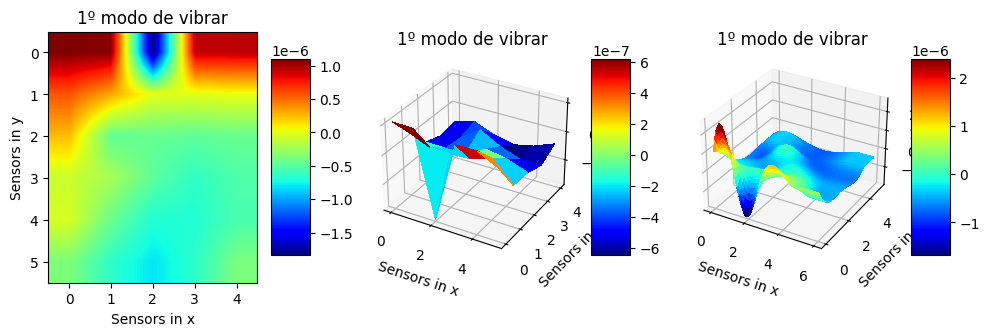

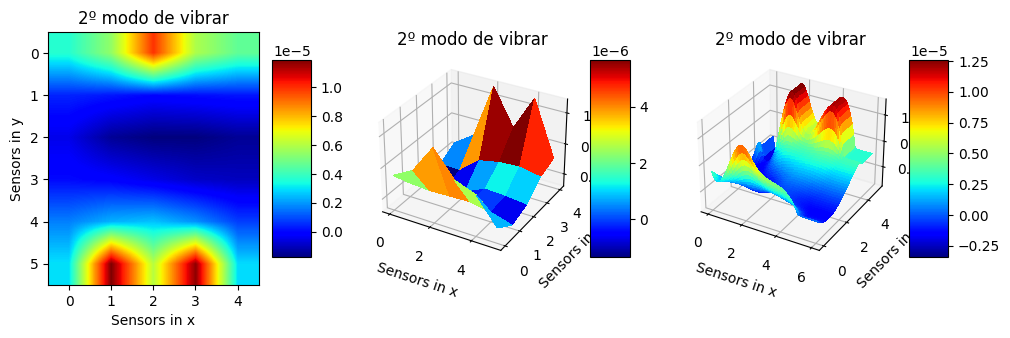

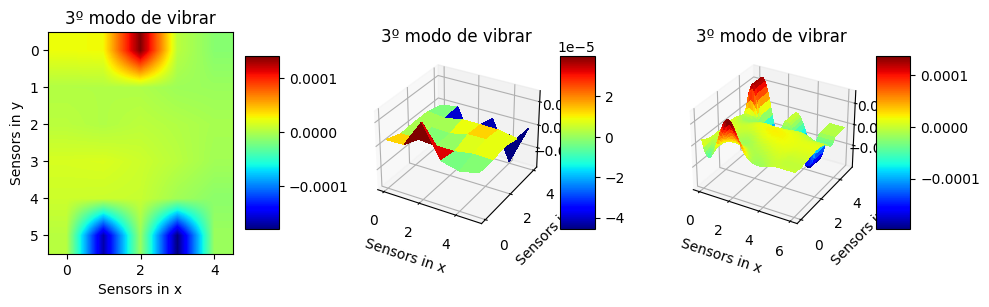

In [80]:
modos = [modo_1, modo_2, modo_3]
for i in range(len(modos)):   
    fig = plt.figure(figsize=(10,10))

    #Heat map
    ax = fig.add_subplot(1, 3, 1)
    heat = modos[i].reshape(6,5)
    heatmap = ax.imshow(heat, interpolation='bilinear', cmap='jet')
    # ax.set_grid(True)
    # ax.set_colorbar(extend='both')
    fig.colorbar(heatmap, shrink=0.5, aspect=5)
    title = f'{i+1}º modo de vibrar'
    ax.set_title(title)
    ax.set_xlabel('Sensors in x')
    ax.set_ylabel('Sensors in y')


    #3d Surface
    X = np.arange(0, 6, 1)
    Y = np.arange(0, 5, 1)
    X, Y = np.meshgrid(X, Y)
    Z = modos[i].reshape((5,6))

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False, rcount=200, ccount=200)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    title = f'{i+1}º modo de vibrar'
    ax.set_title(title)
    ax.set_xlabel('Sensors in x')
    ax.set_ylabel('Sensors in y')


    #Nice 3d surface
    x2 = np.linspace(0, 6, 60)
    y2 = np.linspace(0, 5, 50)
    f = interp2d(X, Y, Z, kind='cubic')
    Z2 = f(x2, y2)

    X2, Y2 = np.meshgrid(x2, y2)
    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    surf = ax.plot_surface(X2, Y2, Z2, cmap='jet', linewidth=0, antialiased=False, rcount=200, ccount=200)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    title = f'{i+1}º modo de vibrar'
    ax.set_title(title)
    ax.set_xlabel('Sensors in x')
    ax.set_ylabel('Sensors in y')
    plt.tight_layout()
    plt.show()